In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
trs = pd.read_parquet("transaction_fraud_data.parquet")
curr = pd.read_parquet("historical_currency_exchange.parquet")

In [3]:
trs['date'] = trs['timestamp'].dt.date

In [4]:
curr_list = curr.melt(
    id_vars=['date'],
    value_vars=list(set(curr.columns)-set("date")),
    var_name='currency',
    value_name='exchange_rate'
)

usd_df = pd.DataFrame({
    'date': curr['date'],
    'currency': 'USD',
    'exchange_rate': 1.0
})

curr_list = pd.concat([curr_list, usd_df])

In [5]:
merged = pd.merge(
    trs,
    curr_list,
    on=['date', 'currency'],
    how='left'
)

In [6]:
merged['amount_usd'] = merged['amount'] / merged['exchange_rate']

In [24]:
merged.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,exchange_rate,amount_usd
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30,0.747153,394.658011
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30,5.434649,619.905757
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,2024-09-30,142.573268,719.506409
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,2024-09-30,1.443654,436.808287
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,2024-09-30,1668.736400,434.430069


In [7]:
merged = merged.drop_duplicates("transaction_id")

In [37]:
# merged.isna().sum()

1. Сравним распределения суммы транзакций в машеннических и обычных сделаках

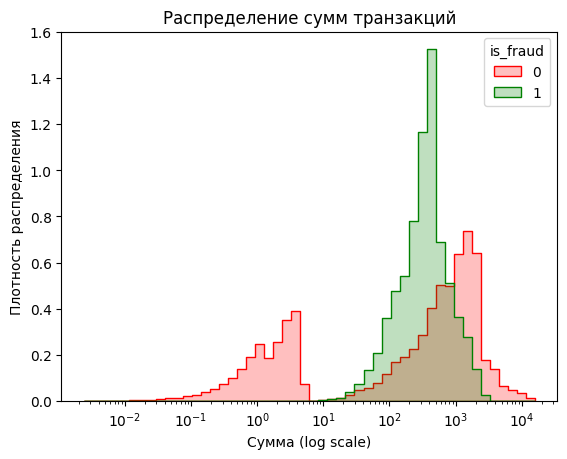

In [40]:
plt.xscale('log')

sns.histplot(data=merged, x='amount_usd', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма (log scale)')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

Как видим распределение мошеннических транзакций с двумя пиками:
* Пик в небольших суммах может говорить о мошеннических схемах, где много раз подряд снимают небольшую сумму, можно отслеживать такие активности и блокировать их.
* Второй пик указывает на более крупные транзакции, возможно, обналичивание средств.

2. Проверим часы активности у фродовых/обычных операций

In [8]:
merged['hour'] = merged['timestamp'].dt.hour

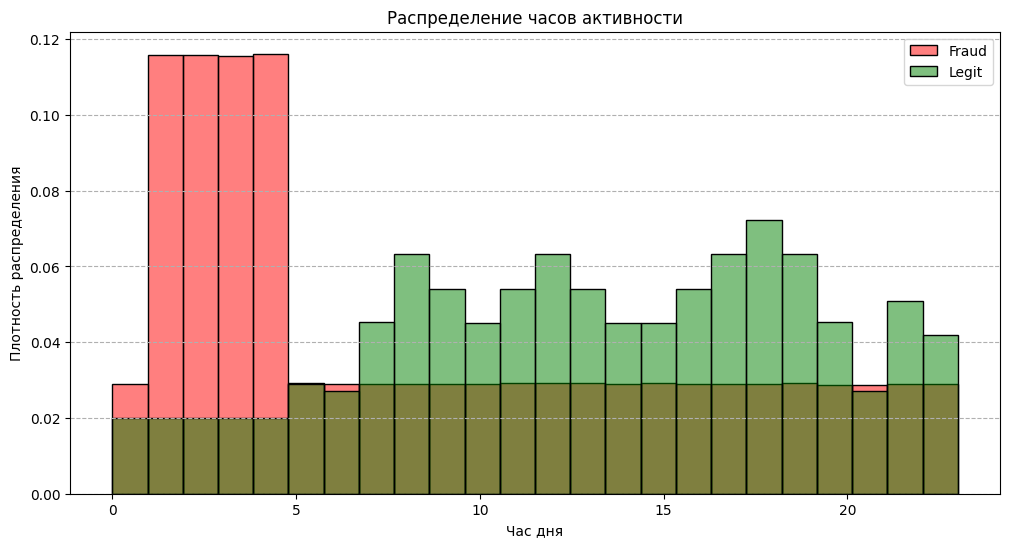

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(data=merged, x='hour', hue='is_fraud', bins=24,
             stat='density', common_norm=False, alpha=0.5,
             palette={True: 'red', False: 'green'})

plt.title('Распределение часов активности')
plt.xlabel('Час дня')
plt.ylabel('Плотность распределения')
plt.legend(labels=['Fraud', 'Legit'])
plt.grid(axis='y', linestyle='--')
plt.show()

Как можно видеть из графика пик фродовых операций приходится на на 1-4 часа ночи, в то время, как активность обычные операции происходят равномерно с утра до вечера.

2.2 Также проверим как ведут себя обычные и фродовые операции на выходных:

In [13]:
merged.groupby(["is_weekend", "is_fraud"]).transaction_id.count()

is_weekend  is_fraud
False       False       4441074
            True        1108367
True        False       1542786
            True         385079
Name: transaction_id, dtype: int64

Доля мошеннических транзакций примерно одинаковая и на выходных и в будние дни

In [16]:
def is_online(s):
  if s == "online":
    return 1
  else:
    return 0

merged["online"] = merged.vendor_type.apply(is_online)

In [24]:
merged.groupby(["online"]).is_fraud.mean()

,is_fraud
online,
0,0.19983
1,0.19930


Доля мошеннических операций онлайн/оффлайн тоже одинаковая

Проверим влияет ли присутствие карты на фрод

In [25]:
merged.groupby(["is_card_present"]).is_fraud.mean()

,is_fraud
is_card_present,
False,0.123477
True,1.000000


In [29]:
merged.groupby(["is_card_present", "is_fraud"]).transaction_id.count()

is_card_present  is_fraud
False            False       5983860
                 True         842952
True             True         650494
Name: transaction_id, dtype: int64

Видим, что во всех мошеннических операций карта присутствовала физически, очень важный признак.

Проверим также влияет ли факт совпадения страны проведения на фрод

In [31]:
merged.groupby(["is_outside_home_country"]).is_fraud.mean()

,is_fraud
is_outside_home_country,
False,0.024900
True,0.567759


Закономерно, если страна проведения операции отличается от страны клиента риск фрода выше, тк мошенники могут находиться в другом месте.

Также проверим рисковость категории вендора:

In [36]:
merged.groupby(["is_high_risk_vendor"]).is_fraud.mean()

,is_fraud
is_high_risk_vendor,
False,0.199641
True,0.200000


Она практически не оказывает влияния

Проверим также связь фрода и последней активности клиента/

In [38]:
def get_num_transactions(d):
  return d["num_transactions"]

merged["num_transactions"] = merged.last_hour_activity.apply(get_num_transactions)

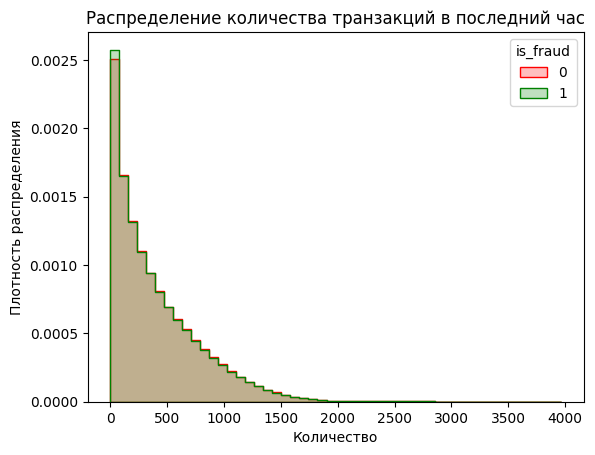

In [43]:
sns.histplot(data=merged, x='num_transactions', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Распределение количества транзакций в последний час')
plt.xlabel('Количество')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

In [44]:
def get_total_amount(d):
  return d["total_amount"]

merged["total_amount"] = merged.last_hour_activity.apply(get_total_amount)
merged["total_amount_usd"] = merged["total_amount"] / merged["exchange_rate"]

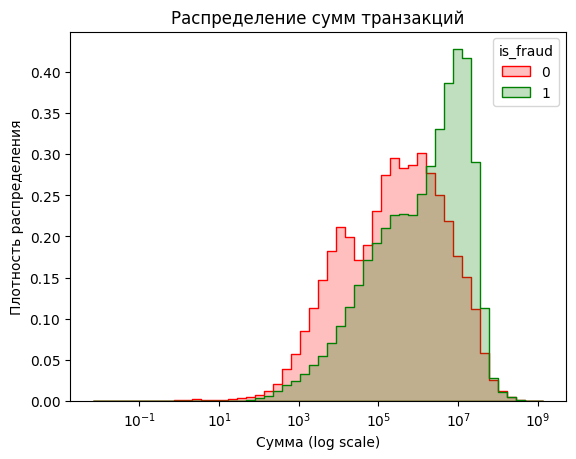

In [45]:
plt.xscale('log')

sns.histplot(data=merged, x='total_amount_usd', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма (log scale)')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

Видим, что среднее фродовых транзакций за последний час ниже

In [40]:
def get_unique_merchants(d):
  return d["unique_merchants"]

merged["unique_merchants"] = merged.last_hour_activity.apply(get_unique_merchants)

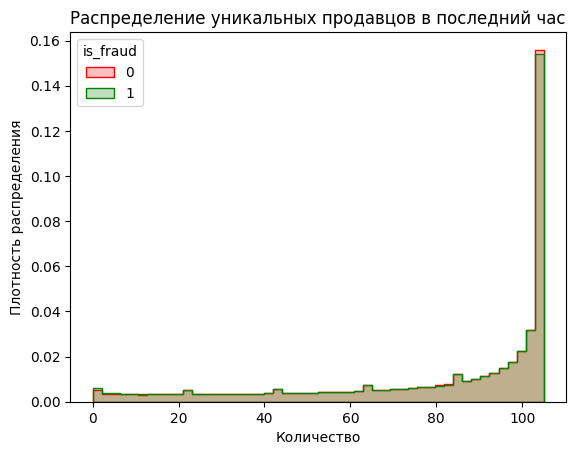

In [46]:
sns.histplot(data=merged, x='unique_merchants', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Распределение уникальных продавцов в последний час')
plt.xlabel('Количество')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

In [41]:
def get_unique_countries(d):
  return d["unique_countries"]

merged["unique_countries"] = merged.last_hour_activity.apply(get_unique_countries)

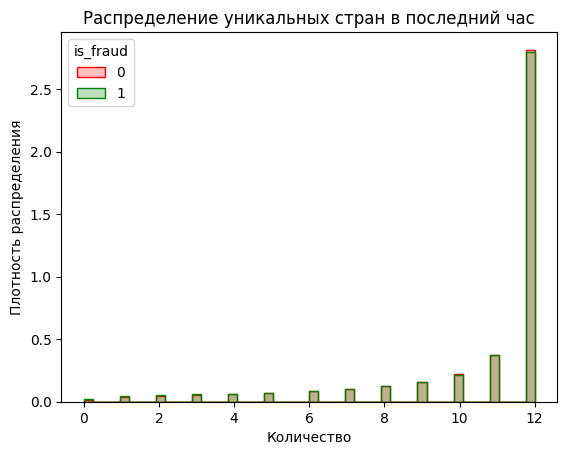

In [47]:
sns.histplot(data=merged, x='unique_countries', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Распределение уникальных стран в последний час')
plt.xlabel('Количество')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

In [42]:
def get_max_single_amount(d):
  return d["max_single_amount"]

merged["max_single_amount"] = merged.last_hour_activity.apply(get_max_single_amount)
merged["max_single_amount_usd"] = merged["max_single_amount"] / merged["exchange_rate"]

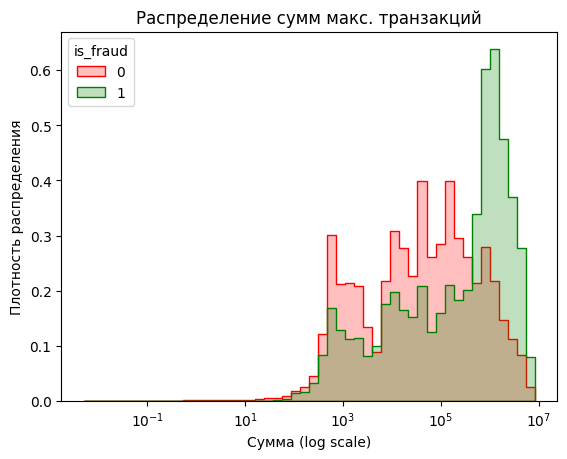

In [48]:
plt.xscale('log')

sns.histplot(data=merged, x='max_single_amount_usd', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Распределение сумм макс. транзакций')
plt.xlabel('Сумма (log scale)')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

Среднее максимальное транзакций у фродовых также ниже

Также проверим различную информацию об устройствах:
1. Посчитаем кол-во уникальных устройств на клиента

In [52]:
devs = merged.groupby(["customer_id", "is_fraud"])["device_fingerprint"].nunique().reset_index()

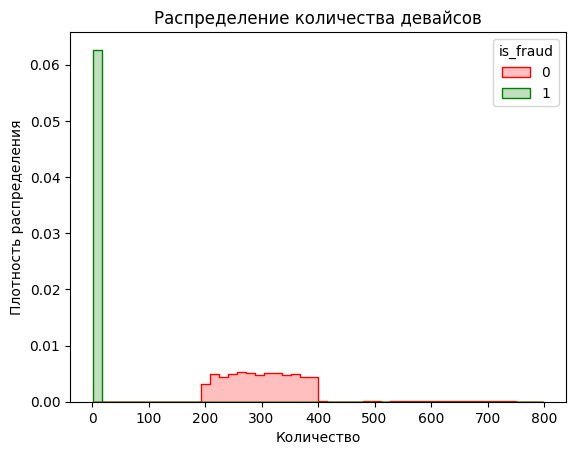

In [55]:
sns.histplot(data=devs, x='device_fingerprint', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Распределение количества девайсов')
plt.xlabel('Количество')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

Как видно из графика при фроде уникальных девайсов в сотни раз больше, чем у обычных операций

2. Посмотрим на канал операции

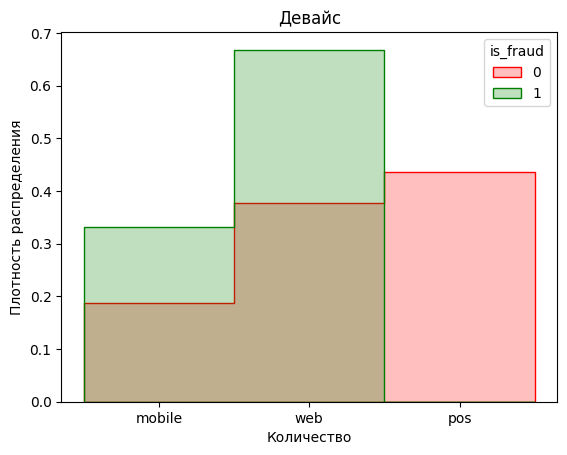

In [56]:
sns.histplot(data=merged, x='channel', hue='is_fraud',
             element='step', stat='density', common_norm=False,
             bins=50, palette={True: 'red', False: 'green'})

plt.title('Девайс')
plt.xlabel('Количество')
plt.ylabel('Плотность распределения')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.show()

Снова увидели, что физическое присутствие карты соответствует фроду